Chemical space of the generated molecules is visualized by t-SNE where each molecule is represented as Morgan fingerprint vectors.

A lot of molecules are used for calculating t-SNE, so the process could take some time.
It took about 1 and a half hour for our machine, with CPU spec (2 of Intel Xeon Gold 6140, each having 18 cores) and 448 GB RAM.

In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import pickle
import json
from logics_pack import global_settings, analysis, chemistry, evaluation
from MulticoreTSNE import MulticoreTSNE as TSNE
import time
import matplotlib.pyplot as plt

project_paths = global_settings.build_project_paths(project_dir='../')
expset_obj = global_settings.ExperimentSettings(project_paths['EXPERIMENT_SETTINGS_JSON'])
expset_obj.get_keys()

Using TensorFlow backend.


dict_keys(['kor-pred-best-cv', 'pik3ca-pred-best-cv', 'kor-logics-best-epoch', 'kor-vgpc-best-epoch', 'kor-segler-best-epoch', 'kor-reinv-best-epoch', 'kor-drugex-best-epoch', 'pik3ca-logics-best-epoch', 'pik3ca-segler-best-epoch', 'pik3ca-vgpc-best-epoch', 'pik3ca-reinv-best-epoch', 'pik3ca-drugex-best-epoch'])

In [3]:
np.random.seed(17)   # fix random seed

In [4]:
# recorded epochs for each model
model_e = {
    'prior': 10, 
    'vgpc':int(expset_obj.get_setting('kor-vgpc-best-epoch')),
    'segler':int(expset_obj.get_setting('kor-segler-best-epoch')), 
    'reinv':int(expset_obj.get_setting('kor-reinv-best-epoch')), 
    'drugex':int(expset_obj.get_setting('kor-drugex-best-epoch')),
    'logics':int(expset_obj.get_setting('kor-logics-best-epoch')),
}

model_names = ['prior','vgpc','segler','reinv','drugex','logics']

In [5]:
# generation fingerprints file paths
paths_npfps = {
    'prior': project_paths['PROJECT_DIR']+'model-prior/prior_npfps_e{}.npy'.format(model_e['prior']),
    'vgpc': project_paths['PROJECT_DIR']+'model-kor/vgpc/kor_vgpc_npfps_e{}.npy'.format(model_e['vgpc']),
    'segler': project_paths['PROJECT_DIR']+'model-kor/segler/kor_segler_npfps_e{}.npy'.format(model_e['segler']),
    'reinv': project_paths['PROJECT_DIR']+'model-kor/reinvent/kor_reinv_npfps_e{}.npy'.format(model_e['reinv']),
    'drugex': project_paths['PROJECT_DIR']+'model-kor/drugex/kor_drugex_npfps_e{}.npy'.format(model_e['drugex']),
    'logics': project_paths['PROJECT_DIR']+'model-kor/logics/kor_logics_npfps_e{}.npy'.format(model_e['logics'])
}

In [ ]:
# 50k random samples from pre-training dataset
# This is used to fix the t-SNE plot axis, considering the ChEMBL molecules forming the large drug-like space
with open(project_paths['PRET_DATA_50K_PATH'], 'r') as f:
    pret_50k_smis = [line.strip() for line in f.readlines()]
pret_50k_npfps = chemistry.rdk2npfps(chemistry.get_fps_from_smilist(pret_50k_smis))

In [ ]:
# loading test set actives (tsa) and separate them from other bioassay records.
affinity_data = pd.read_csv(project_paths['KOR_DATA_PATH'])
with open(project_paths['KOR_FOLD_JSON'], 'r') as f:
    folds = json.load(f)
test_ids = folds[str(global_settings.TEST_FOLD_IDX)]

# extracting test set actives (tsa)
test_data = affinity_data.iloc[test_ids]
test_set_actives = test_data[test_data['affinity']>global_settings.KOR_ACT_THRS]

# non-tsa extraction
non_tsa = affinity_data.drop(test_set_actives.index)

# npfps
tsa_npfps = chemistry.rdk2npfps(chemistry.get_fps_from_smilist(test_set_actives['smiles']))
non_tsa_npfps = chemistry.rdk2npfps(chemistry.get_fps_from_smilist(non_tsa['smiles']))

In [ ]:
# get npfps from each model
model_npfps_list = []   # list of np.array fingerprints of model samples
model_gensz = []   # num of gen size of model
for mn in model_names:    
    npfps = np.load(paths_npfps[mn])
    model_npfps_list.append(npfps)
    model_gensz.append(len(npfps))

In [ ]:
# compute t-SNE
all_npfps_list = model_npfps_list.copy()
all_npfps_list.append(pret_50k_npfps)   # [-3]
all_npfps_list.append(non_tsa_npfps)   # [-2]
all_npfps_list.append(tsa_npfps)   # [-1]
set_sizes = model_gensz.copy()
set_sizes.append(len(pret_50k_npfps))
set_sizes.append(len(non_tsa_npfps))
set_sizes.append(len(tsa_npfps))
all_npfpss = np.vstack(all_npfps_list)

print("Starting tSNE computation ...")
startt = time.time()
tsne_tfr = TSNE(n_components=2, metric="euclidean", perplexity=50, learning_rate=200, n_jobs=64, verbose=1)
all_tsned = tsne_tfr.fit_transform(np.array(all_npfpss))
print("tSNE finished ...")
endt = time.time()
print("time cost: ", endt-startt)

In [ ]:
def split_and_minmax(all_vectors, set_sizes):
    vectors_list = []
    pos = 0
    for i in range(len(set_sizes)):
        vectors_list.append(all_vectors[pos:pos+set_sizes[i]])
        pos += set_sizes[i]
    if len(vectors_list[-1]) != set_sizes[-1]:
        print("[Warning] something is wrong with the set sizes!")
        return None

    xmin, xmax = all_vectors[:,0].min(), all_vectors[:,0].max()
    ymin, ymax = all_vectors[:,1].min(), all_vectors[:,1].max()
    minpos = np.array([xmin, ymin])
    maxpos = np.array([xmax, ymax])
    minmaxpos = np.vstack([minpos, maxpos])
    return vectors_list, minmaxpos

In [ ]:
vectors_list, minmaxpos = split_and_minmax(all_tsned, set_sizes)
pret_tsned = vectors_list[-3]
non_tsa_tsned = vectors_list[-2]
tsa_tsned = vectors_list[-1]
vis_minmaxpos = np.zeros_like(minmaxpos)  # all subplots will have same max and min x y
vis_minmaxpos[0] = minmaxpos[0]-1.0
vis_minmaxpos[1] = minmaxpos[1]+1.0

Drawing t-SNE scatter subplots, where each subplot shows the test set actives and generations from each model

In [24]:
vis_gensz = 2000  # drawing all 20k generations is too much. Let's draw the 2k only.
num_cols = 3
num_m = len(model_names)  # number of models to be drawn
num_rows = int(np.ceil(num_m / num_cols))

gen_kwarg = {'s':40, 'facecolors':'none', 'edgecolors':'blue', 'alpha':0.3, 'linewidth':1.5}
tsa_kwarg = {'s':15, 'c':'red', 'alpha':0.8, 'marker':'x'}

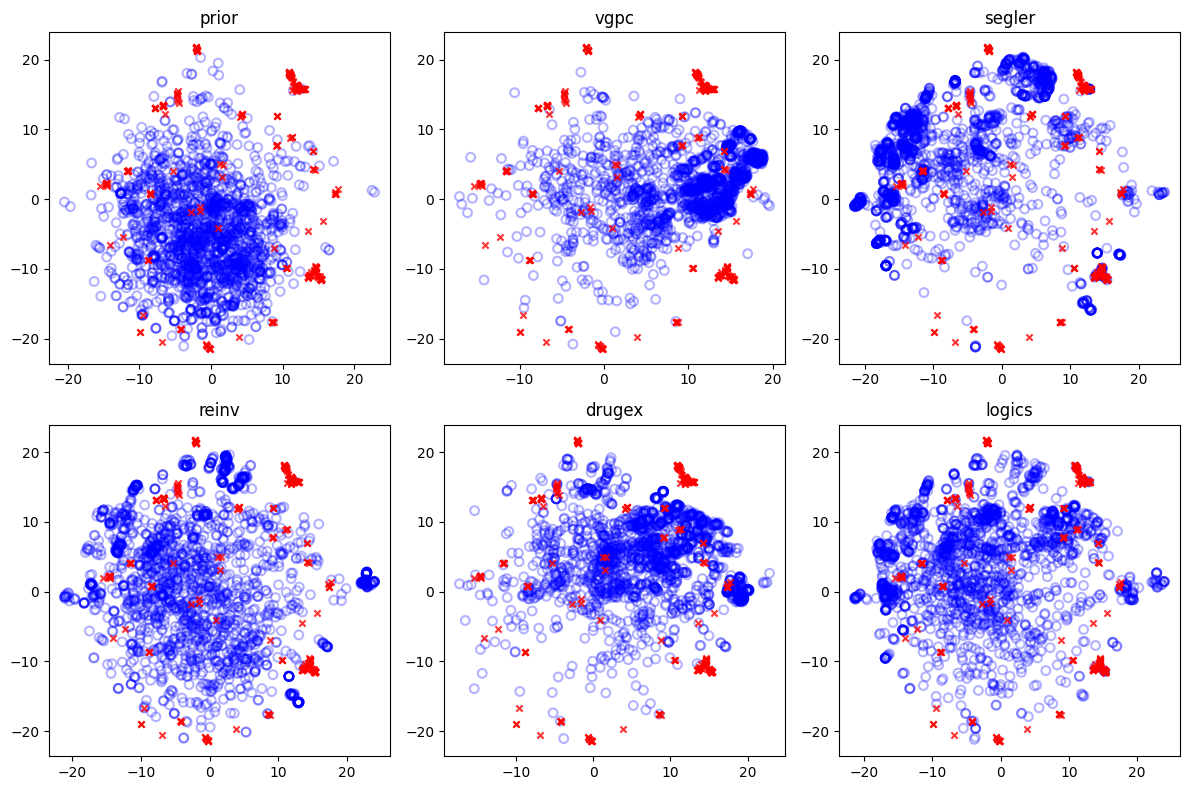

In [31]:
figsize = (12, 8)
fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

for nth in range(num_m):
    row, col = int(nth/num_cols), nth%num_cols   # draw plot at this cell
    gens = vectors_list[nth]
    axes[row,col].scatter(gens[:vis_gensz,0], gens[:vis_gensz,1], **gen_kwarg)
    axes[row,col].scatter(tsa_tsned[:,0], tsa_tsned[:,1], **tsa_kwarg)
    axes[row,col].set_title(model_names[nth])
    
fig.tight_layout()

In [34]:
non_tsa

,smiles,affinity
0,NC(=O)c1cccc(OC2CC3CCC(C2)N3C2(c3ccccc3)CC2)c1,4.62
2,CSCCC(NC(=O)C(Cc1ccccc1)NC(=O)CNC(=O)CNC(=O)C(...,6.68
3,CCC(=O)NCCc1ccc2[nH]c3c(c2c1)CC1(O)C2Cc4ccc(O)...,8.80
4,O=C1C2CCCC1(c1cccc(O)c1)CCN2CCc1ccccc1,6.12
5,COc1ccc2c3c1OC1C(=O)CCC4(O)C(C2)N(CC2CC2)CCC314,6.64
...,...,...
3876,COC12CCC3(CC1COCc1cccc(C)c1)C1Cc4ccc(O)c5c4C3(...,9.54
3877,CN(C(=O)CCCc1ccccc1)C1CCC2(O)C3C(O)c4ccc(O)c5c...,8.12
3878,CCN(CC)C(=S)SSC(=S)N(CC)CC,5.41
3879,NC(=O)C(Cc1ccccc1)NC(=O)C(Cc1c[nH]c2ccccc12)NC...,5.69


In [35]:
test_set_actives

,smiles,affinity
3002,COC12CCC3(CC1C(C)(O)c1ccccc1)C1Cc4ccc(O)c5c4C3...,9.310
121,CC1C2Cc3ccc(C(=O)NCCc4ccc(-c5ccc6c(c5)OCO6)cc4...,9.305
2588,Oc1cccc2c1OC1CCCC3CN(CC4CC4)CCC231,8.570
1093,CC(C)C(CN1CCC(C)(c2cccc(O)c2)C(C)C1)NC(=O)C1Cc...,7.790
585,CC1C2Cc3ccc(C(=O)NCCc4ccc5ccccc5c4)cc3C1(C)CCN...,9.700
...,...,...
3689,COc1ccc(CN2C=C3C4Cc5ccc(OC)cc5C3(CCN4CC3CC3)CC...,7.880
3260,CC(C)CN1CCC23c4cc(O)ccc4CC1C21CCC2C3C(CN2C(=O)...,7.010
1013,Nc1ccc2c(c1)C13CCCCC1C(C2)N(CC1CCC1)CC3,8.740
2821,COC12CCC(=O)C3(C)Oc4c(O)ccc5c4C31CCN(C)C2C5,7.600


In [36]:
affinity_data

,smiles,affinity
0,NC(=O)c1cccc(OC2CC3CCC(C2)N3C2(c3ccccc3)CC2)c1,4.620
1,O=C(Nc1cccc(NC(=O)c2cccc(N3CCOCC3)c2)c1)c1cccc...,8.205
2,CSCCC(NC(=O)C(Cc1ccccc1)NC(=O)CNC(=O)CNC(=O)C(...,6.680
3,CCC(=O)NCCc1ccc2[nH]c3c(c2c1)CC1(O)C2Cc4ccc(O)...,8.800
4,O=C1C2CCCC1(c1cccc(O)c1)CCN2CCc1ccccc1,6.120
...,...,...
3876,COC12CCC3(CC1COCc1cccc(C)c1)C1Cc4ccc(O)c5c4C3(...,9.540
3877,CN(C(=O)CCCc1ccccc1)C1CCC2(O)C3C(O)c4ccc(O)c5c...,8.120
3878,CCN(CC)C(=S)SSC(=S)N(CC)CC,5.410
3879,NC(=O)C(Cc1ccccc1)NC(=O)C(Cc1c[nH]c2ccccc12)NC...,5.690


In [7]:
test_ids

[3002,
 349,
 386,
 121,
 375,
 2702,
 2588,
 1093,
 2086,
 729,
 585,
 2567,
 1210,
 815,
 207,
 412,
 490,
 3431,
 3428,
 3400,
 1887,
 2529,
 1543,
 435,
 1856,
 3863,
 1988,
 2421,
 854,
 2654,
 3110,
 2555,
 1,
 318,
 1321,
 1283,
 3533,
 2756,
 284,
 1545,
 3697,
 741,
 1000,
 1496,
 2485,
 2081,
 1617,
 826,
 2483,
 1268,
 1549,
 1580,
 3639,
 543,
 402,
 1633,
 1269,
 2308,
 38,
 2657,
 1570,
 608,
 450,
 2037,
 228,
 934,
 2865,
 3478,
 3420,
 2829,
 3397,
 3838,
 1886,
 1272,
 3568,
 12,
 3302,
 444,
 777,
 1186,
 1987,
 178,
 153,
 1559,
 1437,
 699,
 1830,
 952,
 1189,
 2579,
 1908,
 3806,
 1812,
 3826,
 2977,
 254,
 1854,
 1569,
 3142,
 3487,
 2158,
 2054,
 137,
 116,
 1182,
 1387,
 3265,
 2036,
 2156,
 2167,
 471,
 3252,
 3286,
 1459,
 921,
 2995,
 2686,
 1429,
 88,
 2743,
 2375,
 1055,
 3092,
 638,
 3865,
 2838,
 499,
 3414,
 2319,
 2176,
 1748,
 3712,
 3660,
 2465,
 1255,
 1864,
 2121,
 2135,
 3389,
 285,
 212,
 607,
 3351,
 949,
 1045,
 2834,
 3603,
 242,
 2198,
 2079,

In [22]:
test_data = affinity_data.loc[test_ids]
test_set_actives = test_data[test_data['affinity']>global_settings.KOR_ACT_THRS]
test_set_actives

,smiles,affinity
3002,COC12CCC3(CC1C(C)(O)c1ccccc1)C1Cc4ccc(O)c5c4C3...,9.310
121,CC1C2Cc3ccc(C(=O)NCCc4ccc(-c5ccc6c(c5)OCO6)cc4...,9.305
2588,Oc1cccc2c1OC1CCCC3CN(CC4CC4)CCC231,8.570
1093,CC(C)C(CN1CCC(C)(c2cccc(O)c2)C(C)C1)NC(=O)C1Cc...,7.790
585,CC1C2Cc3ccc(C(=O)NCCc4ccc5ccccc5c4)cc3C1(C)CCN...,9.700
...,...,...
3689,COc1ccc(CN2C=C3C4Cc5ccc(OC)cc5C3(CCN4CC3CC3)CC...,7.880
3260,CC(C)CN1CCC23c4cc(O)ccc4CC1C21CCC2C3C(CN2C(=O)...,7.010
1013,Nc1ccc2c(c1)C13CCCCC1C(C2)N(CC1CCC1)CC3,8.740
2821,COC12CCC(=O)C3(C)Oc4c(O)ccc5c4C31CCN(C)C2C5,7.600


In [20]:
asdf.index

Int64Index([3002,  349,  386,  121,  375, 2702, 2588, 1093, 2086,  729,
            ...
            3686, 3442, 3260, 1013, 3866,  124, 2821, 3706, 2452,  329],
           dtype='int64', length=651)

In [21]:
test_data.index

Int64Index([3002,  349,  386,  121,  375, 2702, 2588, 1093, 2086,  729,
            ...
            3686, 3442, 3260, 1013, 3866,  124, 2821, 3706, 2452,  329],
           dtype='int64', length=651)

In [23]:
test_set_actives.index

Int64Index([3002,  121, 2588, 1093,  585, 3428, 2529, 3863,  854, 2654,
            ...
            3208, 1802, 2382,  112,  965, 3689, 3260, 1013, 2821,  329],
           dtype='int64', length=292)

In [24]:
test_data.drop(test_set_actives.index)

,smiles,affinity
349,CNC1CC(C(=O)OC)C2(C)CCC3C(=O)OC(c4ccoc4)CC3(C)...,6.28
386,CCc1ccccc1C(c1ccccc1)N1CCC(O)(c2ccccc2)CC1,6.27
375,O=C(Cc1cccc2occc12)NCC12CCCN1CCC2,6.03
2702,COc1ccc2c(c1)C13CCN(C)C(C2)C1Cc1c([nH]c2ccccc1...,6.41
2086,CCc1ccc(S(=O)(=O)NCc2ccc(C(=O)NCCN(Cc3ccccc3)C...,6.09
...,...,...
3442,Cn1cccc1C(=O)Nc1nc2ccccc2n1CCN1CCCC1,6.12
3866,Oc1c(I)cc(Cl)c2cccnc12,5.24
124,Oc1nc2ccccc2n1CCCNCc1cc2c(cc1Cl)OCO2,6.29
3706,COc1ccc(CN2CCC34CCN(CC5CC5)C(Cc5ccc(OC)cc53)C4...,6.69


In [27]:
test_set_actives

,smiles,affinity
3002,COC12CCC3(CC1C(C)(O)c1ccccc1)C1Cc4ccc(O)c5c4C3...,9.310
121,CC1C2Cc3ccc(C(=O)NCCc4ccc(-c5ccc6c(c5)OCO6)cc4...,9.305
2588,Oc1cccc2c1OC1CCCC3CN(CC4CC4)CCC231,8.570
1093,CC(C)C(CN1CCC(C)(c2cccc(O)c2)C(C)C1)NC(=O)C1Cc...,7.790
585,CC1C2Cc3ccc(C(=O)NCCc4ccc5ccccc5c4)cc3C1(C)CCN...,9.700
...,...,...
3689,COc1ccc(CN2C=C3C4Cc5ccc(OC)cc5C3(CCN4CC3CC3)CC...,7.880
3260,CC(C)CN1CCC23c4cc(O)ccc4CC1C21CCC2C3C(CN2C(=O)...,7.010
1013,Nc1ccc2c(c1)C13CCCCC1C(C2)N(CC1CCC1)CC3,8.740
2821,COC12CCC(=O)C3(C)Oc4c(O)ccc5c4C31CCN(C)C2C5,7.600


In [32]:
affinity_data.loc[test_set_actives.index]

,smiles,affinity
3002,COC12CCC3(CC1C(C)(O)c1ccccc1)C1Cc4ccc(O)c5c4C3...,9.310
121,CC1C2Cc3ccc(C(=O)NCCc4ccc(-c5ccc6c(c5)OCO6)cc4...,9.305
2588,Oc1cccc2c1OC1CCCC3CN(CC4CC4)CCC231,8.570
1093,CC(C)C(CN1CCC(C)(c2cccc(O)c2)C(C)C1)NC(=O)C1Cc...,7.790
585,CC1C2Cc3ccc(C(=O)NCCc4ccc5ccccc5c4)cc3C1(C)CCN...,9.700
...,...,...
3689,COc1ccc(CN2C=C3C4Cc5ccc(OC)cc5C3(CCN4CC3CC3)CC...,7.880
3260,CC(C)CN1CCC23c4cc(O)ccc4CC1C21CCC2C3C(CN2C(=O)...,7.010
1013,Nc1ccc2c(c1)C13CCCCC1C(C2)N(CC1CCC1)CC3,8.740
2821,COC12CCC(=O)C3(C)Oc4c(O)ccc5c4C31CCN(C)C2C5,7.600
